In [1]:
#%% Import modules
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from maad import sound, util, rois
from maad.rois import template_matching
from pathlib import Path
import pickle

In [2]:

TEMPLATE_AUDIO_1 = Path('/Users/ernestocediel/OneDrive - Universidad de los Andes/MSDS/DATA 590 Capstone I & II/ravenpro_test/buzz/20210910_030000_time2303_LFbuzz.wav')
TEMPLATE_AUDIO_2 = Path('/Users/ernestocediel/OneDrive - Universidad de los Andes/MSDS/DATA 590 Capstone I & II/ravenpro_test/20210910_033000.WAV')
TEMPLATE_AUDIO_3 = Path('/Users/ernestocediel/OneDrive - Universidad de los Andes/MSDS/DATA 590 Capstone I & II/ravenpro_test/20210910_030000.WAV')
TEMPLATE_PATH = Path('/Users/ernestocediel/OneDrive - Universidad de los Andes/MSDS/DATA 590 Capstone I & II/ravenpro_test/templates')
#PATH_AUDIO = Path('/Users/kirsteenng/Desktop/UW/DATA 590/sample_wav/20210910_030000_time2303_LFbuzz.wav')
#PATH_AUDIO = '/Users/kirsteenng/Desktop/UW/DATA 590/sample_wav/20210921_030000_time1054_LFbuzz_varyFreq.wav'
#PATH_AUDIO = '/Users/kirsteenng/Desktop/UW/DATA 590/sample_wav/20210910_030000_time2303_LFbuzz.wav'
#PATH_AUDIO = Path('/Users/kirsteenng/Desktop/UW/DATA 590/workflow/2_clipped_audio_wav/20210910_033000/20210910_033000__0.00_1500.00.wav')
PATH_AUDIO = Path('/Users/ernestocediel/OneDrive - Universidad de los Andes/MSDS/DATA 590 Capstone I & II/ravenpro_test/buzz/20210910_030000_time2303_LFbuzz.wav')
RESULTS_DIR = Path('/Users/ernestocediel/OneDrive - Universidad de los Andes/MSDS/DATA 590 Capstone I & II/ravenpro_test/results')
# Set spectrogram parameters
tlims = { 'template_1':(9.762, 10.059),
          'template_2_1':(70.637, 71.328),
          'template_2_2':(620.663, 620.854),
          'template_2_3':(898.079, 898.368),
          'template_2_4':(1189.957, 1190.130),
          'template_3_1':(608.139,	608.452),
          'template_3_2':(744.961, 745.0877),
          'template_3_3':(1065.034, 1065.228),
          'template_3_4':(1098.204, 1098.519)

        }
flims = { 'template_1':(14532.7, 29760.3),
          'template_2_1':(19745, 28638.2),
          'template_2_2':(12434.9,29910.9),
          'template_2_3':(11426.6, 25205.9),
          'template_2_4':(12434.9, 23021.3),
          'template_3_1':(14328.0,30138.3),
          'template_3_2':(10375.5, 47430.83),
          'template_3_3':(14328, 25691.7),
          'template_3_4':(17272, 34565.5)

        }
nperseg = 1024
noverlap = 512
window = 'hann'
db_range = 80

In [5]:
#Functions
def generate_template(template_audio_path:Path, template_path:Path, template_dict:dict, freq_type:str, flims:tuple, tlims:tuple):
    # we want to create template, save it and update the template dictionary
    template_name = 'template_{}_{}_{}_{}'.format(freq_type,template_audio_path.stem, tlims[0], tlims[1])
    if template_name not in template_dict:
        s_template, fs_template = sound.load(template_audio_path)
        Sxx_template, _, _, _ = sound.spectrogram(s_template, fs_template, window, nperseg, noverlap, flims, tlims)
        # we update the dictionary
        template_dict[template_name] = (Sxx_template, freq_type, flims, tlims)    
        # we save the template
        with open(template_path / template_name, 'wb') as handle:
            pickle.dump(Sxx_template, handle, protocol=pickle.HIGHEST_PROTOCOL)
    return template_dict

def load_templates(template_path:Path):
    #Ideally we should be able to choose which templates to load, for now we will load all
    try:
        with open(template_path / 'template_dict.pickle', 'wb') as handle:
            template_dict = pickle.load(handle)
    except:
        # if it's the first time creating template dict
        template_dict = dict()
    return template_dict
def save_template_dict(template_dict:dict, template_path: Path):
        # we save the updated dict
    with open(template_path / 'template_dict.pickle', 'wb') as handle:
        pickle.dump(template_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)

def template_matching_loop(PATH_AUDIO:Path, result_dir:Path, template:np.ndarray,flims:tuple, peak_th:float, db_range:int = 80,):
    suffix = PATH_AUDIO.stem
    s, fs = sound.load(PATH_AUDIO)
    #tlims_target = (5.413,6.083)
    flims_target = (16940,49000)

    #peak_th = 0.2
    peak_distance = 0.1

    # Compute spectrogram for target audio
    Sxx_audio, tn, fn, ext = sound.spectrogram(s, fs, window, nperseg, noverlap, flims)
    Sxx_audio = util.power2dB(Sxx_audio, db_range)
    xcorrcoef, rois = template_matching(Sxx_audio, template, tn, ext, peak_th, peak_distance)
    rois['min_f'] = flims[0]
    rois['max_f'] = flims[1]
    print(rois)
    rois.to_csv(Path(result_dir,'feeding_buzz_csv',"{}.csv".format(suffix)))

    # plot
    Sxx, tn, fn, ext = sound.spectrogram(s, fs, window, nperseg, noverlap)
    fig, ax = plt.subplots(2,1, figsize=(8, 5), sharex=True)
    util.plot_spectrogram(Sxx, ext, db_range=80, ax=ax[0], colorbar=False)
    
    util.overlay_rois(Sxx, util.format_features(rois, tn, fn), fig=fig, ax=ax[0])
    ax[1].plot(tn[0: xcorrcoef.shape[0]], xcorrcoef)
    ax[1].hlines(peak_th, 0, tn[-1], linestyle='dotted', color='0.75')
    ax[1].plot(rois.peak_time, rois.xcorrcoef, 'x')
    ax[1].set_xlabel('Time [s]')
    ax[1].set_ylabel('Correlation coeficient')
    fig.savefig(result_dir/"bat_calls_detected_{}.png".format(suffix),format="png")
    plt.show()
    plt.close()        

In [ ]:
template_dict = load_templates(TEMPLATE_PATH)
template_dict = generate_template(TEMPLATE_AUDIO_1,TEMPLATE_PATH, template_dict, 'lf',tlims = tlims['template_1'], flims = flims['template_1'])
template_dict = generate_template(TEMPLATE_AUDIO_2,TEMPLATE_PATH, template_dict, 'lf',tlims = tlims['template_2_1'], flims = flims['template_2_1'])
template_dict = generate_template(TEMPLATE_AUDIO_2,TEMPLATE_PATH, template_dict, 'lf',tlims = tlims['template_2_2'], flims = flims['template_2_2'])
template_dict = generate_template(TEMPLATE_AUDIO_2,TEMPLATE_PATH, template_dict, 'lf',tlims = tlims['template_2_3'], flims = flims['template_2_3'])
template_dict = generate_template(TEMPLATE_AUDIO_2,TEMPLATE_PATH, template_dict, 'lf',tlims = tlims['template_2_4'], flims = flims['template_2_4'])
template_dict = generate_template(TEMPLATE_AUDIO_3,TEMPLATE_PATH, template_dict, 'lf',tlims = tlims['template_3_1'], flims = flims['template_3_1'])
template_dict = generate_template(TEMPLATE_AUDIO_3,TEMPLATE_PATH, template_dict, 'hf',tlims = tlims['template_3_2'], flims = flims['template_3_2'])
template_dict = generate_template(TEMPLATE_AUDIO_3,TEMPLATE_PATH, template_dict, 'lf',tlims = tlims['template_3_3'], flims = flims['template_3_3'])
template_dict = generate_template(TEMPLATE_AUDIO_3,TEMPLATE_PATH, template_dict, 'lf',tlims = tlims['template_3_4'], flims = flims['template_3_4'])
save_template_dict(template_dict, TEMPLATE_PATH)


1 done
2 done


/opt/anaconda3/envs/transformer4batsss/lib/python3.9/site-packages/maad/sound/input_output.py:113: WavFileWarning: Chunk (non-data) not understood, skipping it.
  fs, s = wavfile.read(filename)


   peak_time  xcorrcoef     min_t      max_t    min_f    max_f
0   5.054464   0.251071  4.905984   5.202944  14532.7  29760.3
1   9.910272   0.636333  9.761792  10.058752  14532.7  29760.3


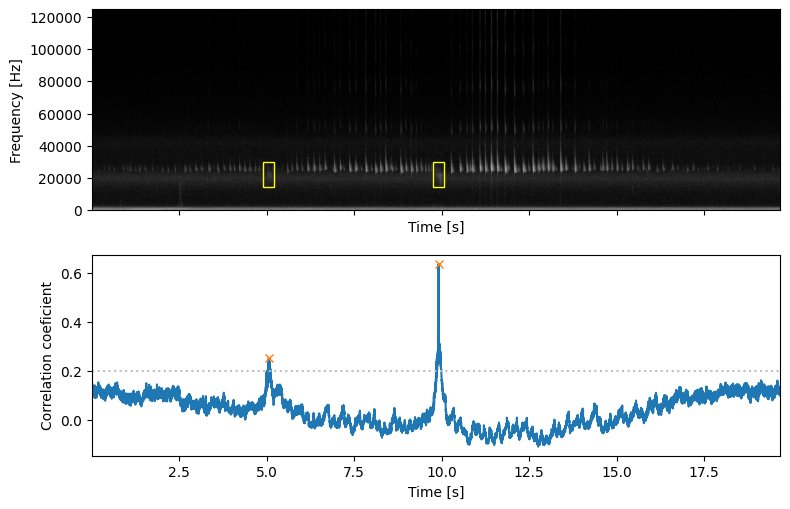

/opt/anaconda3/envs/transformer4batsss/lib/python3.9/site-packages/maad/sound/input_output.py:113: WavFileWarning: Chunk (non-data) not understood, skipping it.
  fs, s = wavfile.read(filename)


Empty DataFrame
Columns: [peak_time, xcorrcoef, min_t, max_t, min_f, max_f]
Index: []


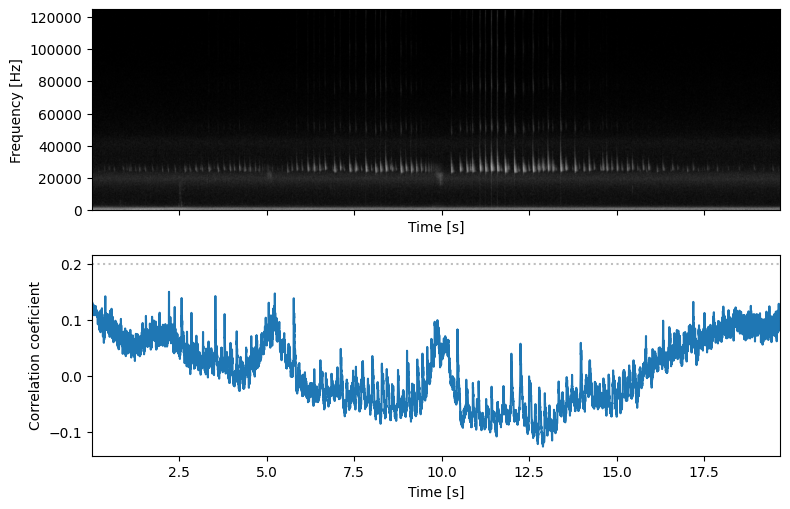

In [25]:
for template in template_dict.values():
    Sxx_template, freq_type, flims, tlims = template
    template_matching_loop(PATH_AUDIO, RESULTS_DIR, Sxx_template, flims, 0.2)

In [20]:
template_dict

{'template_hf_20210910_030000_time2303_LFbuzz_9.762_10.059': (array([[3.60478277e-08, 5.89496912e-08, 5.73689703e-08, ...,
          1.02984523e-07, 3.06782152e-08, 6.47922614e-08],
         [2.92265742e-09, 4.92058270e-08, 2.89726667e-08, ...,
          4.85985436e-08, 1.77861903e-08, 6.96376086e-08],
         [7.89901267e-08, 5.80932957e-08, 6.86578389e-09, ...,
          8.76802010e-08, 7.43623532e-08, 4.22605564e-08],
         ...,
         [3.15480114e-09, 1.49403303e-08, 2.54665025e-08, ...,
          2.96620075e-09, 9.16928715e-09, 3.67602741e-09],
         [2.36755013e-08, 1.30691166e-09, 8.95107712e-09, ...,
          1.77443129e-08, 3.16606745e-09, 3.96333802e-10],
         [1.46324333e-09, 1.77060486e-08, 2.21541804e-08, ...,
          1.01348359e-07, 2.14557106e-08, 9.08565205e-09]]),
  'hf',
  (14532.7, 29760.3),
  (9.762, 10.059)),
 'template_hf_20210910_033000_70.637_71.328': (array([[1.10529988e-08, 3.25375037e-07, 3.76987840e-07, ...,
          2.56407426e-07, 4.104153

In [12]:
import pandas as pd
  
# Define a dictionary containing employee data
data = {'Name':['Jai', 'Princi', 'Gaurav', 'Anuj', 'Geeku'],
        'Age':[27, 24, 22, 32, 15],
        'Address':['Delhi', 'Kanpur', 'Allahabad', 'Kannauj', 'Noida'],
        'Qualification':['Msc', 'MA', 'MCA', 'Phd', '10th']}
 
# Convert the dictionary into DataFrame
df = pd.DataFrame(data)
 
# Select one row randomly using sample()
# without give any parameters
df.sample()

,Name,Age,Address,Qualification
4,Geeku,15,Noida,10th


In [2]:
type(df.sample())

pandas.core.frame.DataFrame

In [3]:
df.sample()['Name']

2    Gaurav
Name: Name, dtype: object

In [9]:
temp =np.where()

In [10]:
temp.index

Int64Index([0, 1, 3], dtype='int64')

In [11]:
df.drop(temp.index,inplace=True)
df

,Name,Age,Address,Qualification
2,Gaurav,22,Allahabad,MCA
4,Geeku,15,Noida,10th
